In [1]:
import keras
import tensorflow as tf
import numpy as np
from keras import layers
from keras import ops
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [101]:
# load data
import numpy as np
x = np.load("/content/drive/My Drive/x_letters.npy")
y=np.load("/content/drive/My Drive/y_letters.npy")

In [102]:
x = x.astype(np.float32)
y = y.astype(np.int64)

In [103]:
y = to_categorical(y, num_classes=26)

In [104]:
x.shape, y.shape

((88799, 28, 28), (88799, 26))

In [106]:
batch_size = 64
dataset = tf.data.Dataset.from_tensor_slices((x, y))
dataset = dataset.shuffle(buffer_size=1000, reshuffle_each_iteration=True).batch(batch_size)

In [38]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, data):
        real_images, real_classes = data
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim),
            seed = self.seed_generator
        )

        generated_images = self.generator([random_latent_vectors, real_classes])

        real_images = real_images * 2 - 1
        combined_images = ops.concatenate([generated_images, real_images], axis=0)
        combined_classes = ops.concatenate([real_classes, real_classes], axis=0)

        labels = ops.concatenate(
            [ops.ones((batch_size, 1)) * 0.9, ops.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        #basically makes sure the discriminator is not perfect,
        #so that the generator never has a chance to learn
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator([combined_images, combined_classes])
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)

        grads = [tf.clip_by_value(g, -1.0, 1.0) for g in grads]

        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim),
            seed = self.seed_generator
        )

        # Assemble labels that say "all real images"
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            generated_images = self.generator([random_latent_vectors, real_classes])
            predictions = self.discriminator([generated_images, real_classes])
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        # Clip gradients for stability
        grads = [tf.clip_by_value(g, -1.0, 1.0) for g in grads]
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [46]:
latent_dim = 64
n_classes=y.shape[1]


def build_generator():
    noise_input = keras.Input(shape=(latent_dim,))
    label_input = keras.Input(shape=(n_classes,))

    x = layers.Concatenate(axis=-1)([noise_input, label_input])

    x = keras.layers.Dense(128, use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.8)(x)
    x = keras.layers.LeakyReLU(0.2)(x)

    x = keras.layers.Dense(256, use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.8)(x)
    x = keras.layers.LeakyReLU(0.2)(x)

    x = keras.layers.Dense(28*28, activation='tanh')(x)
    output = layers.Reshape((28, 28))(x)

    return keras.Model([noise_input, label_input], output, name="generator")


def build_discriminator():
    image_input = keras.Input(shape=(28, 28))
    label_input = keras.Input(shape=(n_classes,))


    x = layers.Flatten()(image_input)

    x = keras.layers.Dense(256)(x)
    x = keras.layers.LeakyReLU(0.2)(x)
    x = keras.layers.Dropout(0.4)(x)

    x = keras.layers.Dense(128)(x)
    x = keras.layers.LeakyReLU(0.2)(x)
    x = keras.layers.Dropout(0.4)(x)

    x = keras.layers.Concatenate(axis=-1)([x, label_input])

    x = keras.layers.Dense(64)(x)
    x = keras.layers.LeakyReLU(0.2)(x)

    output = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model([image_input, label_input], output, name="discriminator")


generator = build_generator()
discriminator = build_discriminator()


gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(
        learning_rate=0.0002,
        beta_1=0.5,
        beta_2=0.999
    ),
    g_optimizer=keras.optimizers.Adam(
        learning_rate=0.0001,
        beta_1=0.5,
        beta_2=0.999
    ),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

In [47]:
gan.fit(dataset, epochs=200)

Epoch 1/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - d_loss: 0.3309 - g_loss: 1.7465
Epoch 2/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.2966 - g_loss: 2.3289
Epoch 3/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.2966 - g_loss: 2.2568
Epoch 4/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3171 - g_loss: 2.1899
Epoch 5/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3170 - g_loss: 2.2602
Epoch 6/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3177 - g_loss: 2.2561
Epoch 7/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3103 - g_loss: 2.3028
Epoch 8/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3081 - g_loss: 2.3181
Epoch 9/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3140 - g_loss: 2.2993
Epoch 10/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3144 - g_loss: 2.2893
Epoch 11/200
1388/1388 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - d_loss: 0.3109 - g_loss: 2.2929
Epoch 12/200
1388/

In [48]:
MAPPING_TABLE = {
    'a': 0,
    'b': 1,
    'c': 2,
    'd': 3,
    'e': 4,
    'f': 5,
    'g': 6,
    'h': 7,
    'i': 8,
    'j': 9,
    'k': 10,
    'l': 11,
    'm': 12,
    'n': 13,
    'o': 14,
    'p': 15,
    'q': 16,
    'r': 17,
    's': 18,
    't': 19,
    'u': 20,
    'v': 21,
    'w': 22,
    'x': 23,
    'y': 24,
    'z': 25
}

def generate_letter(letter):
  mapped_letter = MAPPING_TABLE[letter]
  random_latent_vectors = keras.random.normal(shape=(1, latent_dim))
  one_hot_label = (ops.one_hot(mapped_letter, num_classes=n_classes))
  one_hot_label = tf.expand_dims(one_hot_label, axis=0)
  generated_images = gan.generator([random_latent_vectors, one_hot_label])
  generated_images = generated_images.numpy()[0]

  return generated_images

In [88]:
def plot_string(word):

  _, ax = plt.subplots(1, len(word), figsize=(len(word)*2, 2))
  for i in range(len(word)):
    generated_letter = generate_letter(word[i])
    ax[i].imshow(generated_letter, cmap='gray')
    ax[i].axis('off')

  plt.subplots_adjust(wspace=0, hspace=0)
  plt.show()

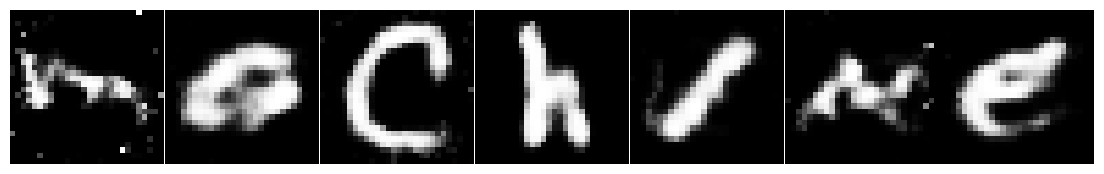

In [89]:
plot_string("machine")

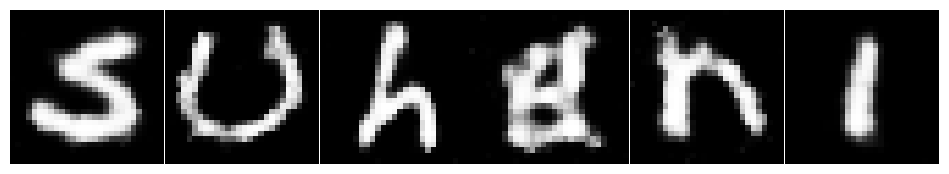

In [93]:
plot_string("suhani")

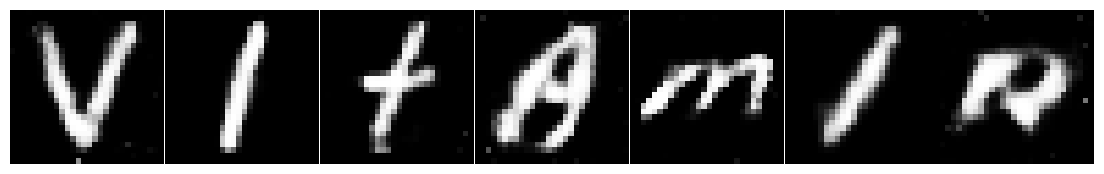

In [96]:
plot_string("vitamin")

### Learning from Assignment
- Generating letters with curves and rounded shapes was initially more
challenging.
-Reducing the latent dimension significantly impacted the results.
- Increasing the number of epochs from 100 to 200 improved performance.
- Continuously adjusting the learning rates helped achieve better outcomes.